In [1]:
# -*- coding: utf-8 -*-
"""
@author: Kaan Kocabas
"""


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ImageClassification:
    """
        Classify images with given dataset
        using cnn and lstm-rnn algorithms
        
        alg='cnn', 'lstm_rnn'
        dataset_name='cifar10', 'mnist', 'fashion_mnist'
    """

    def __init__(self, alg='cnn'):
        self.alg = alg
        self.dataset = None
        self.dataset_name = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.y_all = None
        self.x_all = None
        self.input_shape = None
        # Categorized real values
        self.y_cat_train = None
        self.y_cat_test = None
        self.model = None
        self.num_classes = 0
        self.complexity = 0
        # dataset classes
        self.fashion_map = {
            0: "T-shirt/top",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle boot"
        }
        self.cifar10_map = {
            0: "Airplane",
            1: "Automobile",
            2: "Bird",
            3: "Cat",
            4: "Deer",
            5: "Dog",
            6: "Frog",
            7: "Horse",
            8: "Ship",
            9: "Truck"
        }

    def fit(self, dataset_name='mnist', num_classes=10, epochs=10, verbose=1,
            show_model_summary=True, patience=2, monitor='val_loss', complexity=0):
        self.setup(dataset_name, show_model_summary, self.alg, num_classes, complexity)
        early_stop = self.__generate_early_stop__(patience, monitor)

        fit = self.model.fit(self.__reshape_if_necessary__(self.x_train), self.y_cat_train,
                             validation_data=(self.__reshape_if_necessary__(self.x_test), self.y_cat_test),
                             epochs=epochs, callbacks=[early_stop], verbose=verbose)

        self.__plot_history__(fit=fit, param1='loss', param1_label='Loss',
                              param2='val_loss', param2_label='Validation Loss')
        self.__plot_history__(fit=fit, param1='accuracy', param1_label='Accuracy',
                              param2='val_accuracy', param2_label='Validation Accuracy')

    def predict(self, X=None):
        if X is None:
            X = self.x_test
        return self.model.predict_classes(self.__reshape_if_necessary__(X))

    def setup(self, dataset_name, show_model_summary, alg, num_classes, complexity):
        self.num_classes = num_classes
        self.complexity = complexity
        self.dataset_name = dataset_name
        self.__handle_dataset__(dataset_name)
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.dataset.load_data()
        self.x_all = np.append(self.x_train, self.x_test, axis=0)
        self.y_all = np.append(self.y_train, self.y_test, axis=0)
        self.input_shape = self.__handle_input_shape__(self.alg, self.x_train)
        self.__normalize_input_data__()
        self.__categorize_real_values()
        self.model = self.__generate_model__(self.alg, show_model_summary, self.input_shape,
                                             self.num_classes, complexity)

    def get_confusion_matrix(self, predictions, real_values=None):
        if real_values is None:
            real_values = self.y_test
        return confusion_matrix(real_values, predictions)

    def plot_heatmap(self, conf_matrix=None, predictions=None, real_values=None, title=None, figsize=(12,9)):
        if conf_matrix is None:
            conf_matrix = self.get_confusion_matrix(predictions, real_values)

        plt.figure(figsize=figsize)
        plt.title(title)
        sns.heatmap(conf_matrix, annot=True)
        plt.xlabel('Prediction')
        plt.ylabel('Real Value')
        
    def get_accuracy_score(self, predictions, real_values=None, normalize=True):
        if real_values is None:
            real_values = self.y_test
        return accuracy_score(real_values, predictions, normalize=normalize)
        
    def get_history(self):
        return self.model.history.history

    def plot_rand_misclassified(self, predictions, iteration=1, rgb=1, figsize=(12,9)):
        # Reshape the test as an array
        reshaped_y_test = self.y_test.reshape(self.y_test.shape[0])
        for i in range(iteration):
            plt.figure(figsize=figsize)
            misclassified = np.where(predictions != reshaped_y_test)[0]
            i = np.random.choice(misclassified)
            if self.dataset_name == 'fashion_mnist':
                plt.title('True label: %s Predicted: %s' % (self.fashion_map[reshaped_y_test[i]],
                                                            self.fashion_map[predictions[i]]))
            elif self.dataset_name == 'cifar10':
                plt.title('True label: %s Predicted: %s' % (self.cifar10_map[reshaped_y_test[i]],
                                                            self.cifar10_map[predictions[i]]))
            else:
                plt.title('True label: %s Predicted %s' % (reshaped_y_test[i], predictions[i]))

            plt.imshow(self.x_test[i], cmap='gray' if rgb == 1 else None)

    def __handle_dataset__(self, dataset):
        if dataset == 'fashion_mnist':
            self.dataset = tf.keras.datasets.fashion_mnist
        elif dataset == 'cifar10':
            self.dataset = tf.keras.datasets.cifar10
        else:
            self.dataset = tf.keras.datasets.mnist

    def __normalize_input_data__(self):
        self.x_train, self.x_test = self.x_train / 255.0, self.x_test / 255.0

    def __categorize_real_values(self):
        self.y_cat_test = to_categorical(self.y_test)
        self.y_cat_train = to_categorical(self.y_train)

    def __handle_input_shape__(self, alg, x_train):
        input_shape = list(x_train.shape)
        input_shape.pop(0)

        if alg == 'cnn':
            if len(input_shape) == 2:
                input_shape.append(1)
        elif alg == 'lstm_rnn':
            if len(input_shape) == 3:
                input_shape[-2] *= input_shape[-1]
                input_shape.pop()
        input_shape = tuple(input_shape)
        return input_shape

    def __generate_model__(self, alg, show_summary, input_shape, num_classes, complexity):
        if alg == 'cnn':
            return self.__generate_cnn__(show_summary, input_shape, num_classes, complexity)
        elif alg == 'lstm_rnn':
            return self.__generate_lstm_rnn__(show_summary, input_shape, num_classes, complexity)

        return self.__generate_lstm_rnn__(show_summary, input_shape, num_classes, complexity)


    def __generate_cnn__(self, show_summary, input_shape, num_classes, complexity):
        model = Sequential()
        if complexity == 0:
            model.add(Conv2D(filters=32, kernel_size=(3, 3),
                             input_shape=input_shape, activation='relu'))
            model.add(MaxPool2D((2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPool2D((2, 2)))
            model.add(Dropout(0.2))

            model.add(Flatten())
        else:
            model.add(Conv2D(filters=32, kernel_size=(3, 3),
                             input_shape=input_shape, activation='relu'))
            model.add(MaxPool2D((2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPool2D((2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPool2D((2, 2)))
            model.add(Dropout(0.2))

            model.add(Flatten())

            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))

        # OUTPUT ==> Softmax used because of Multi class problem
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])
        if show_summary:
            model.summary()

        return model

    def __generate_lstm_rnn__(self, show_summary, input_shape, num_classes, complexity):
        if complexity == 0:
            model = Sequential()
            model.add((LSTM(32, activation='relu', input_shape=input_shape,
                            return_sequences=True)))
            model.add(Dropout(0.2))

            model.add(LSTM(64, activation='relu'))
            model.add(Dropout(0.2))
        else:
            model = Sequential()
            model.add((LSTM(32, activation='relu', input_shape=input_shape,
                            return_sequences=True)))
            model.add(Dropout(0.2))

            model.add(LSTM(64, activation='relu', return_sequences=True))
            model.add(Dropout(0.2))

            model.add(LSTM(64, activation='relu'))
            model.add(Dropout(0.2))

            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))

        # OUTPUT ==> Softmax used because of Multi class problem
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])
        if show_summary:
            model.summary()

        return model

    def __reshape_if_necessary__(self, X):
        # if the algorithm is cnn add one more dimension to data (.., .., ..) --> (.., .., .., 1)
        if self.alg == 'cnn':
            if len(X.shape) == 3:
                return self.__expand_dims__(X)
        if self.alg == 'lstm_rnn':
            if len(X.shape) == 4:
                X = X.reshape(X.shape[0], X.shape[1], X.shape[2]*X.shape[3])
                return X
        return X

    def __expand_dims__(self, data):
        return np.expand_dims(data, -1)

    def __generate_early_stop__(self, patience, monitor):
        return EarlyStopping(monitor=monitor, patience=patience)

    def __plot_history__(self, fit, param1='loss', param1_label='Loss', param2='val_loss',
                         param2_label='Validation Loss', title=None):
        plt.figure()
        plt.title(title)
        plt.plot(fit.history[param1], label=param1 if param1_label is None else param1_label)

        if param2 is not None:
            label = param2_label if param2_label is not None else param2
            plt.plot(fit.history[param2], label=label)

        plt.legend()
        plt.show()

# Object creation
#### Create the object

In [3]:
ic_cnn = ImageClassification('cnn')

In [4]:
ic_lstm = ImageClassification('lstm_rnn')

# Fitting. 
#### You can use 'mnist', 'fashion_mnist', 'cifar10'. It will generate and train the model. And than plots the accuracy and loss.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

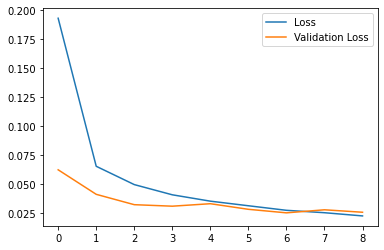

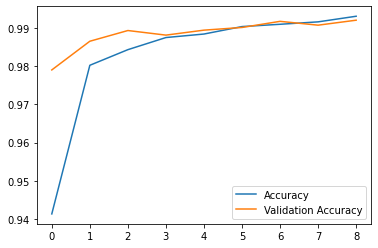

In [5]:
ic_cnn.fit(complexity=0, dataset_name='mnist')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 32)            7808      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 64)            24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

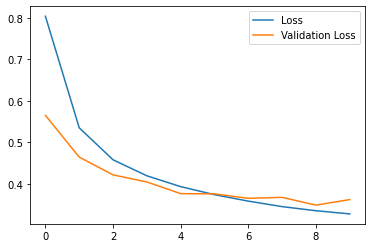

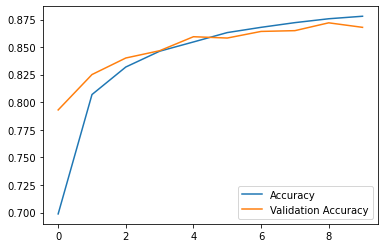

In [6]:
ic_lstm.fit(complexity=1, dataset_name='fashion_mnist')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

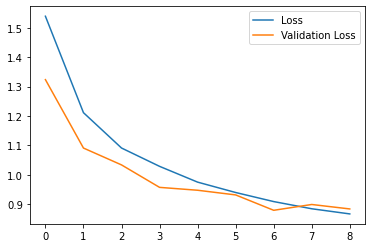

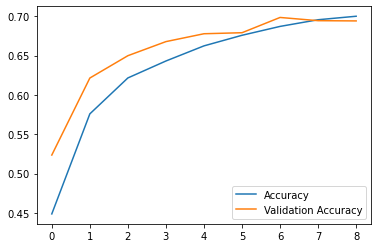

In [7]:
ic_cnn_cifar = ImageClassification('cnn')
ic_cnn_cifar.fit(complexity=0, dataset_name='cifar10')

### CNN & LSTM-RNN Accuracy Table

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32, 32)            16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 64)            24832     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

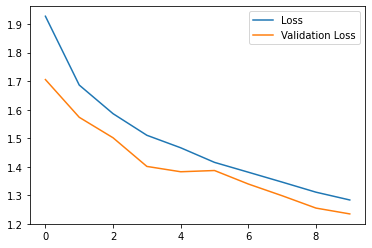

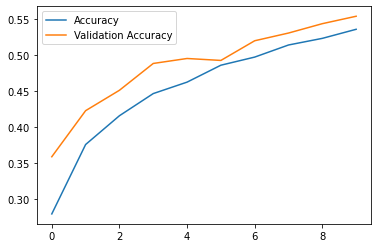

In [8]:
ic_lstm_cifar = ImageClassification('lstm_rnn') 
ic_lstm_cifar.fit(complexity=1, dataset_name='cifar10')

# Predictions
### Predictions of all the data - CNN Mnist
##### Heatmaps of the confusion matrices shown below

/Users/kaan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


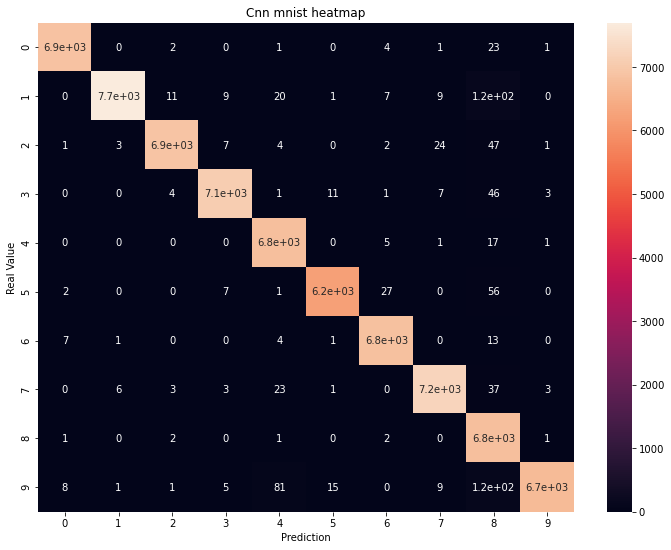

In [9]:
predictions_cnn_all = ic_cnn.predict(ic_cnn.x_all)
ic_cnn.plot_heatmap(predictions=predictions_cnn_all, real_values=ic_cnn.y_all, title='Cnn mnist heatmap')

### Predictions of the test data - CNN Mnist

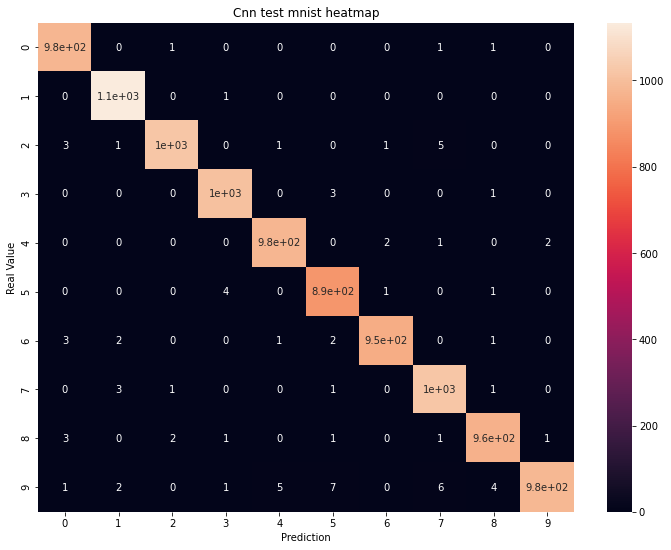

In [10]:
predictions_cnn = ic_cnn.predict(ic_cnn.x_test)
ic_cnn.plot_heatmap(predictions=predictions_cnn, title='Cnn test mnist heatmap')

In [11]:
accuracy_score(ic_cnn.y_test, predictions_cnn)

0.992

### Predictions of the train data - CNN Mnist

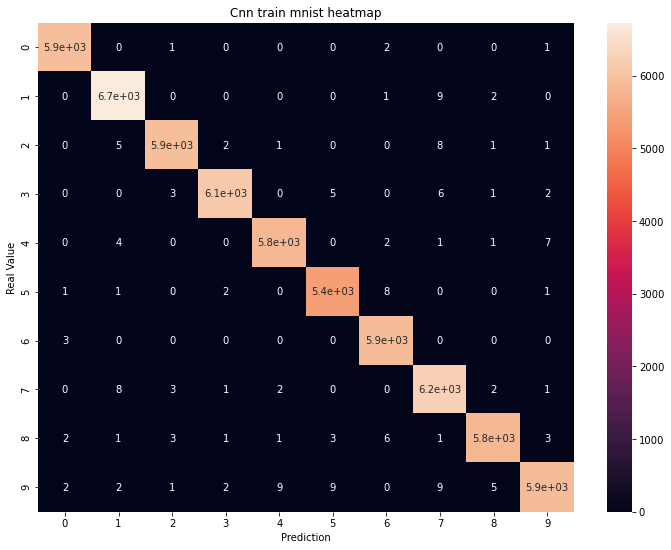

In [12]:
predictions_cnn_train = ic_cnn.predict(ic_cnn.x_train)
ic_cnn.plot_heatmap(predictions=predictions_cnn_train, real_values=ic_cnn.y_train, title='Cnn train mnist heatmap')

In [13]:
accuracy_score(ic_cnn.y_train, predictions_cnn_train)

0.99735

### Plot random misclassified test examples - CNN Mnist 

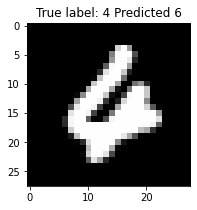

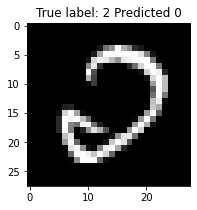

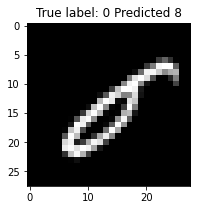

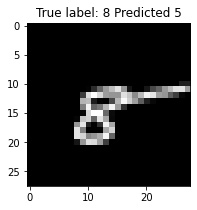

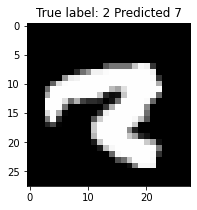

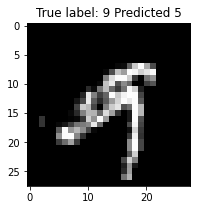

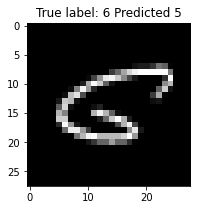

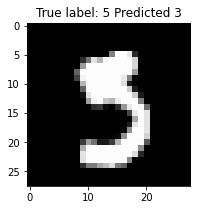

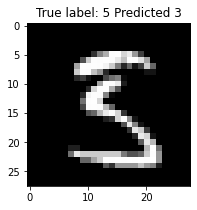

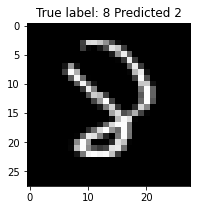

In [14]:
ic_cnn.plot_rand_misclassified(predictions=predictions_cnn, iteration=10, rgb=1, figsize=(3,3))

### Predictions of the test data - LSTM-RNN Fashion Mnist

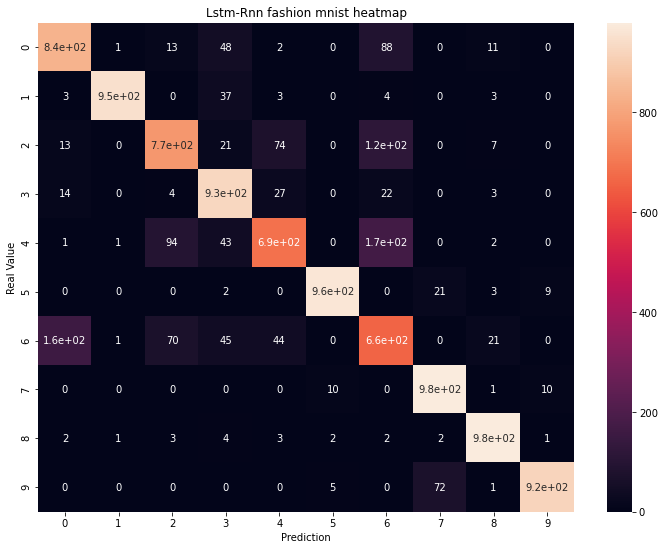

In [15]:
predictions_lstm = ic_lstm.predict(ic_lstm.x_test)
ic_lstm.plot_heatmap(predictions=predictions_lstm, title='Lstm-Rnn fashion mnist heatmap')

In [16]:
accuracy_score(ic_lstm.y_test, predictions_lstm)

0.8679

### Predictions of the train data - LSTM-RNN Fashion Mnist

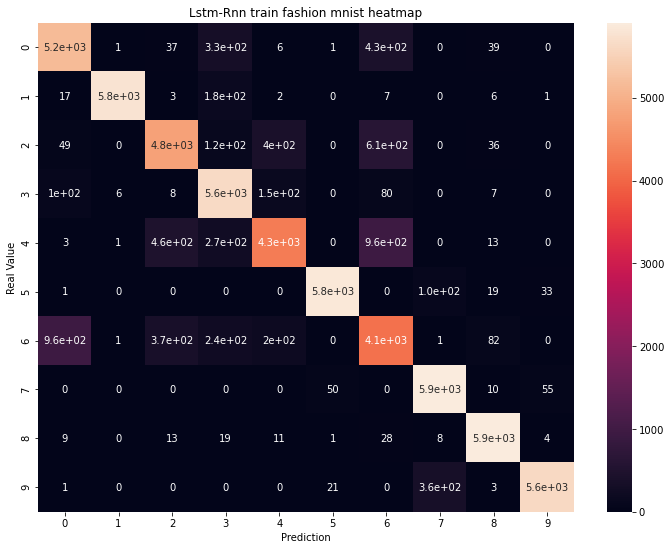

In [17]:
predictions_lstm_train = ic_lstm.predict(ic_lstm.x_train)
ic_lstm.plot_heatmap(predictions=predictions_lstm_train, real_values=ic_lstm.y_train,
                     title='Lstm-Rnn train fashion mnist heatmap')

In [18]:
accuracy_score(ic_lstm.y_train, predictions_lstm_train)

0.8842166666666667

### Plot random misclassified test examples - LSTM-RNN Fashion Mnist

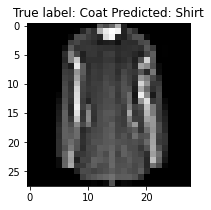

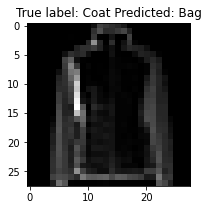

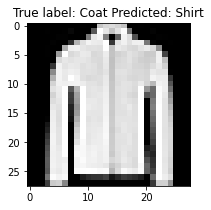

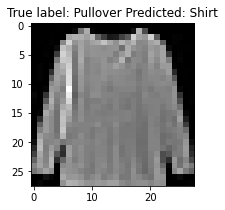

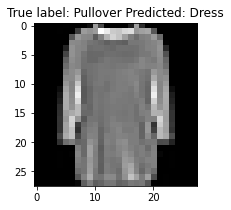

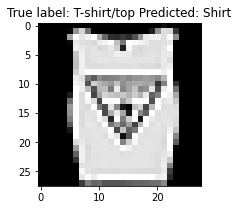

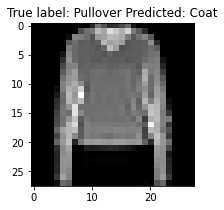

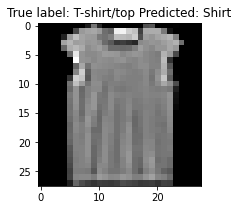

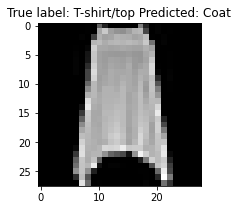

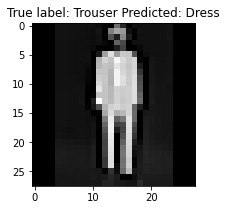

In [19]:
ic_lstm.plot_rand_misclassified(predictions=predictions_lstm, iteration=10, rgb=1, figsize=(3,3))

### Predictions of the test data - CNN Cifar10

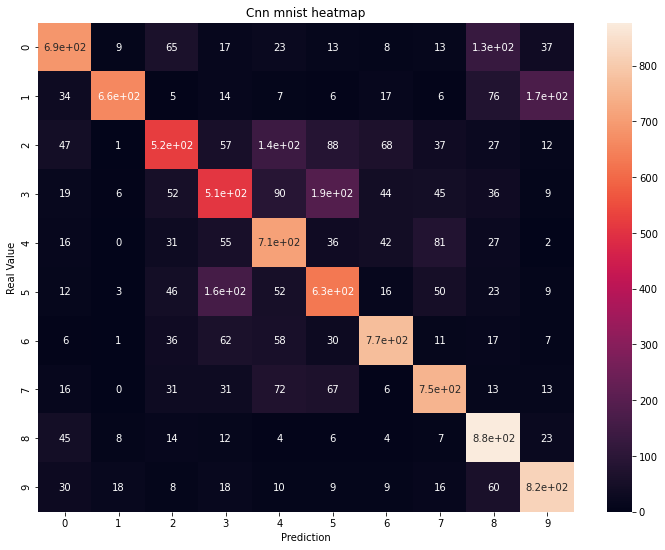

In [20]:
predictions_cnn_cifar = ic_cnn_cifar.predict(ic_cnn_cifar.x_test)
ic_cnn_cifar.plot_heatmap(predictions=predictions_cnn_cifar, title='Cnn mnist heatmap')

In [21]:
accuracy_score(ic_cnn_cifar.y_test, predictions_cnn_cifar)

0.694

### Predictions of the train data - CNN Cifar10

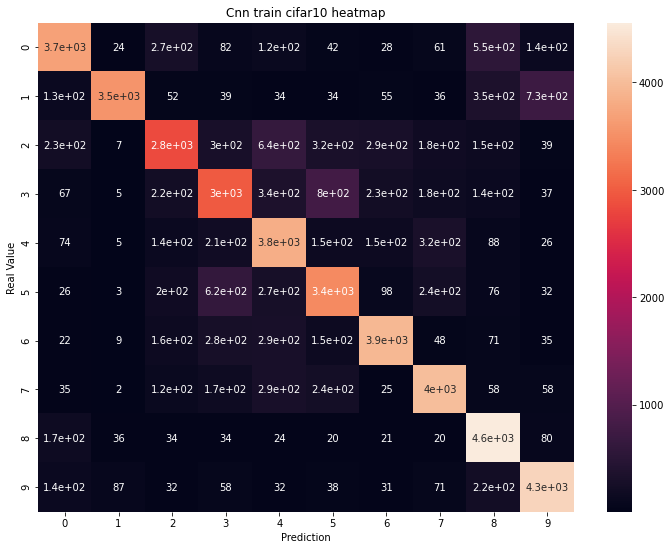

In [22]:
predictions_cnn_cifar_train = ic_cnn_cifar.predict(ic_cnn_cifar.x_train)
ic_lstm.plot_heatmap(predictions=predictions_cnn_cifar_train, real_values=ic_cnn_cifar.y_train,
                     title='Cnn train cifar10 heatmap')

In [23]:
accuracy_score(ic_cnn_cifar.y_train, predictions_cnn_cifar_train)

0.7425

### Plot random misclassified test examples - CNN Cifar10

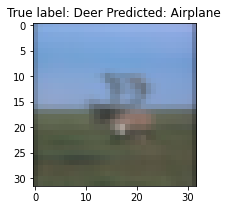

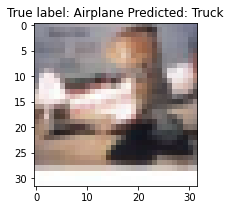

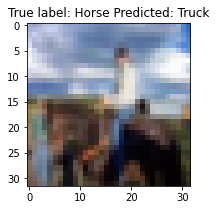

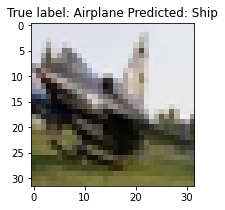

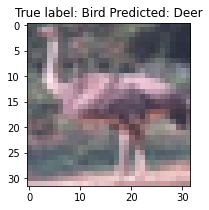

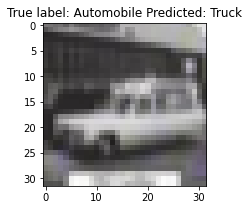

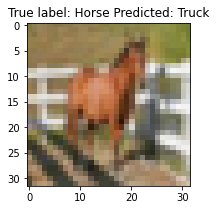

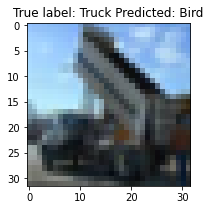

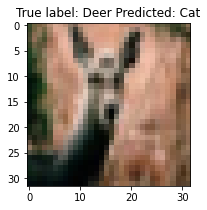

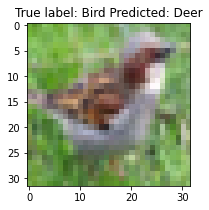

In [24]:
ic_cnn_cifar.plot_rand_misclassified(predictions=predictions_cnn_cifar, iteration=10, rgb=3, figsize=(3,3))

### Predictions of the test data - LSTM-RNN Cifar10

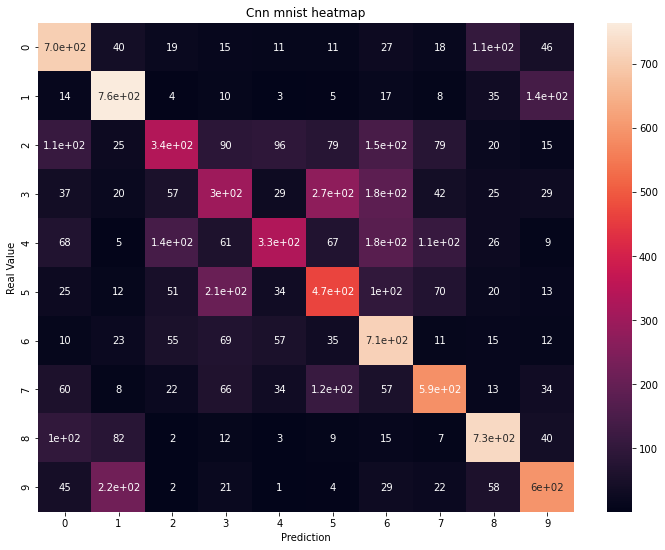

In [25]:
predictions_lstm_cifar = ic_lstm_cifar.predict(ic_lstm_cifar.x_test)
ic_lstm_cifar.plot_heatmap(predictions=predictions_lstm_cifar, title='Cnn mnist heatmap')

In [26]:
accuracy_score(ic_lstm_cifar.y_test, predictions_lstm_cifar)

0.5538

### Predictions of the train data - LSTM-RNN Cifar10

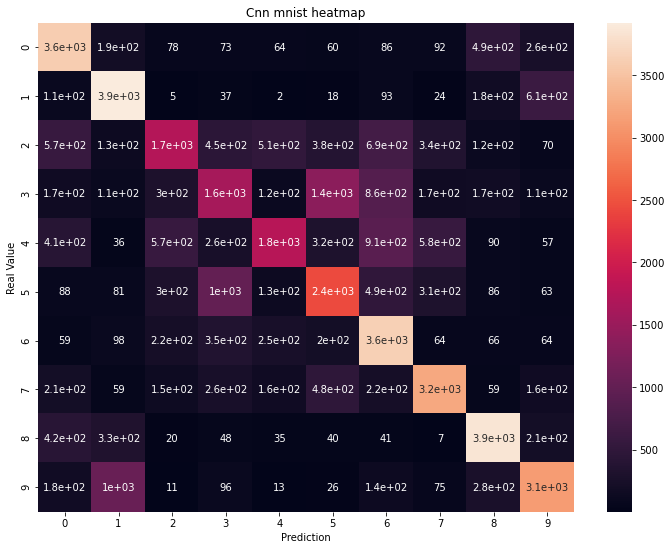

In [27]:
predictions_lstm_cifar_train = ic_lstm_cifar.predict(ic_lstm_cifar.x_train)
ic_lstm_cifar.plot_heatmap(predictions=predictions_lstm_cifar_train, real_values=ic_lstm_cifar.y_train,
                           title='Cnn mnist heatmap')

In [28]:
accuracy_score(ic_lstm_cifar.y_train, predictions_lstm_cifar_train)

0.57944

### Plot random misclassified test examples - CNN Cifar10

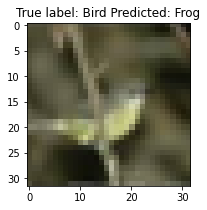

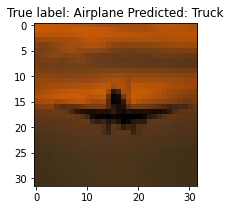

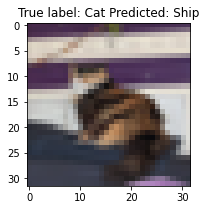

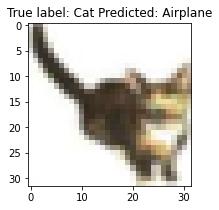

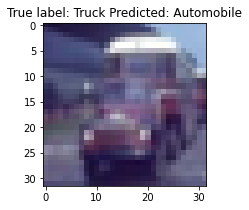

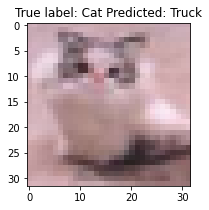

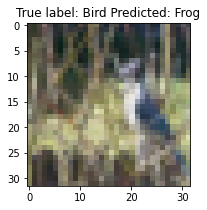

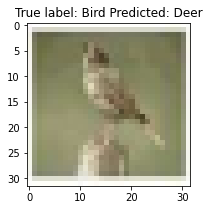

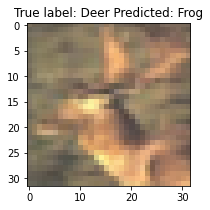

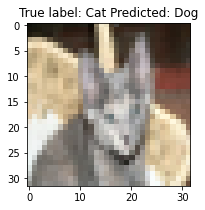

In [29]:
ic_lstm_cifar.plot_rand_misclassified(predictions=predictions_lstm_cifar, iteration=10, rgb=3, figsize=(3,3))